progress: [2, 202, 27, 514, 'AZ.RDM.', '20220113031908700']
1 arrivals
	sPvmP phase arrival at 17.383 seconds
TP=6.111s  TsPmP=17.383s  TsPn=nans


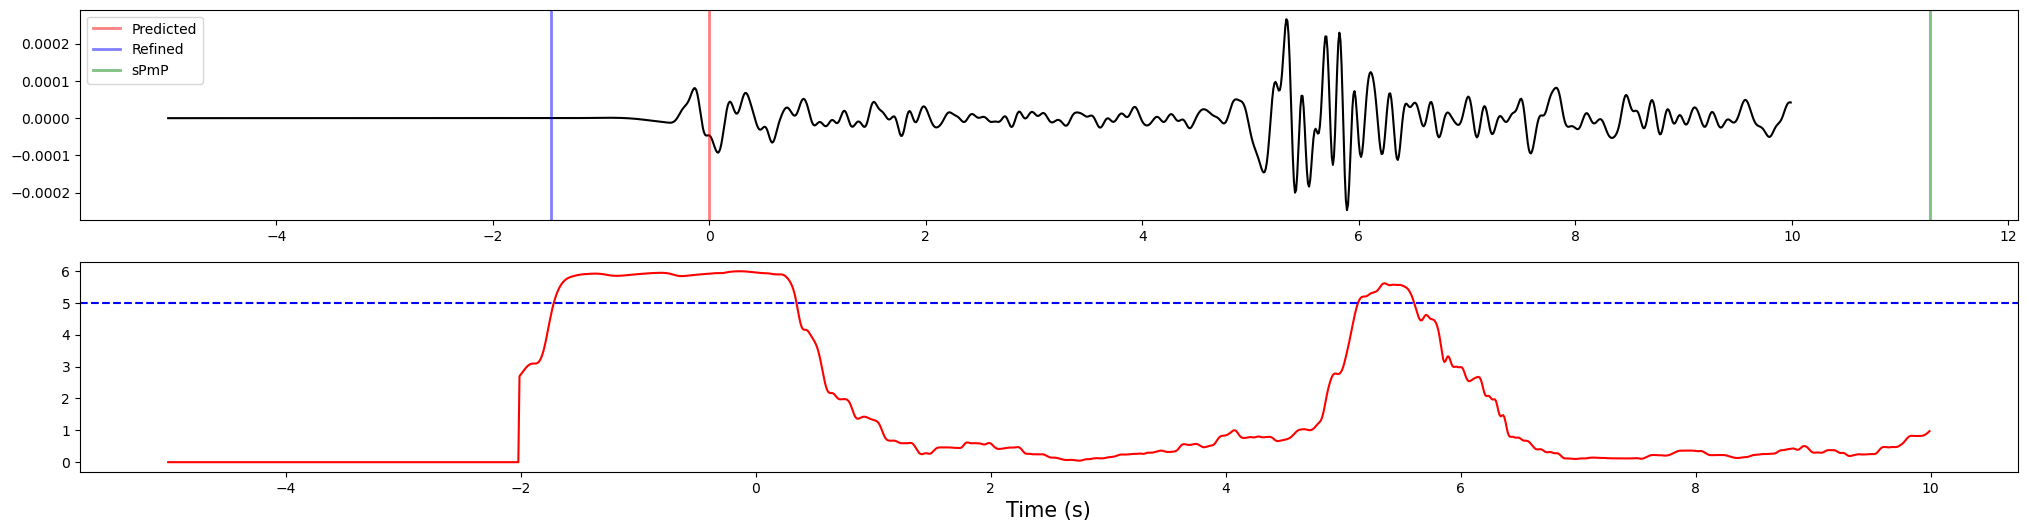

In [ ]:
#  refine P-wave arrival and calculate theoretical sP-P differential time
import os
import glob
import obspy
import time
from obspy.taup import TauPyModel
from obspy.clients.iris import Client
client = Client()
import matplotlib.pyplot as plt
import numpy as np
from obspy.signal.trigger import classic_sta_lta
from IPython.display import clear_output
switch1 = True
switch2 = True

data_sac="./Download/SAC"
file = open("./judge.info", "a")
file.close()
file2 = open("./progression.info", "r")

overall_progress = file2.read().split()
evt = overall_progress[1]
sacfile_name = overall_progress[0]


file2.close()
total = len(os.listdir(data_sac))
events = os.listdir(data_sac)
for ev in events:
        #print(ev)
        if ev != evt and switch1 == True:
            continue
        switch1 = False

        inpath = os.path.join(data_sac, ev)
        if len(glob.glob(f"{inpath}/*R.SAC.bp.cut")) == 0:
            continue
        else:            
            funiq = []
            for sac in glob.glob(f"{inpath}/*R.SAC.bp.cut"):
                st = obspy.read(sac)
                funiq.append("{}.{}.{}".format(st[0].stats.network,st[0].stats.station,st[0].stats.location))
            fU = sorted(set(funiq))
            subTotal = len(fU)
           
            for sacfile in fU:
                iteration2 = iter(fU)
                
                if switch2 == True and sacfile != sacfile_name:
                    continue
                switch2 = False
                        
                progress = [fU.index(sacfile), len(fU), events.index(ev), len(events), sacfile, ev]
                print("progress:", progress)
                file2 = open("./progression.info", "w")
                file2.write(f" {sacfile} {ev}")
                file2.close()
                
                st = obspy.read(f"{inpath}/{sacfile}*[RTZ].SAC.bp.cut")

                ### refine P-wave arrival using sta/lta method
                df = st[0].stats.sac.delta
                t = np.arange(st[0].stats.sac.t1-5, st[0].stats.sac.t1+10, st[0].stats.delta)
                # time window
                idx1 = int((st[0].stats.sac.t1-5-st[0].stats.sac.b)/st[0].stats.delta)
                idx2 = int((st[0].stats.sac.t1+10-st[0].stats.sac.b)/st[0].stats.delta)
                cft = classic_sta_lta(st[2].data[idx1:idx2], int(0.5/df), int(3/df))   # 0.5s short-term window; 3.0s long-term window
                if len(np.where(cft>5)[0]) != 0:
                    Tp = -5 + np.where(cft>5)[0][0]*df + 0.25 - st[0].stats.sac.o
                else:
                    Tp = 0 - st[0].stats.sac.o

                ### calculate the theoretical sP-P differential time
                model = TauPyModel(model="iasp91")
                sachd = st[0].stats.sac
                distaz = client.distaz(sachd["stla"], sachd["stlo"], sachd["evla"], sachd["evlo"])
                gcarc = distaz['distance']
                
                if sachd["evdp"] < 0:
                    arrival = model.get_travel_times(source_depth_in_km=0,distance_in_degree=gcarc, phase_list=["sPvmP"])
                else:                                  
                    arrival = model.get_travel_times(source_depth_in_km=sachd["evdp"],distance_in_degree=gcarc, phase_list=["sPvmP"])
                print(arrival)
                try:
                    TsPmP = arrival[0].time
                except: 
                    continue
                arrival = model.get_travel_times(source_depth_in_km=sachd["evdp"],distance_in_degree=gcarc, phase_list=["sPn"])
                if len(arrival) != 0:
                    TsPn = float("{:.3f}".format(arrival[0].time))
                else:
                    TsPn = "nan"
                print("TP={:.3f}s  TsPmP={:.3f}s  TsPn={}s".format(Tp,TsPmP,TsPn))

                ### Plot the waveform
                plt.figure(figsize=(25,6))
                plt.subplot(211)
                plt.plot(t,st[2].data[idx1:idx2],color="black")
                plt.axvline(x=st[2].stats.sac.t1, color="red", alpha=0.5, linewidth=2,label="Predicted")
                if len(np.where(cft>5)[0]) != 0:
                    plt.axvline(x=-5+np.where(cft>5)[0][0]*df+0.25, color="blue", alpha=0.5, linewidth=2,label="Refined")
                plt.axvline(x=TsPmP-Tp, color="green", alpha=0.5, linewidth=2, label="sPmP")
                if TsPn != "nan":
                    plt.axvline(x=TsPn-Tp, color="cyan", alpha=0.5, linewidth=2, label="sPn")
                plt.legend()

                plt.subplot(212)
                plt.plot(t,cft,color="red")
                plt.axhline(y=5, color='blue', linestyle='--')
                plt.xlabel("Time (s)",fontsize=15)
                plt.show()
                quality = input("Quality: y(good) or n(bad)")
                
                if quality == "y":
                    file = open("./judge.info", "a")
                    file.write("Info: {} {} Tp: {} TsPmP: {} TsPn: {}\n".format(ev, sacfile, Tp, TsPmP, TsPn))
                    file.close()
                clear_output(wait=True)
                
